In [1]:
import numpy as np
import h5py
from tqdm.notebook import tqdm
# import matplotlib.pyplot as plt
from pde import MemoryStorage

from methods.base import BaseConfig
from methods.io_things import add_data_to_h5dataset, split_hdf5_random 

from methods.plotting import plot_perm, plot_press_plan, plot_event_list, plot_ev_dens_slice
from methods.pore_press_calc_functions import Diffusion_with_Source_and_Gravity, test_wells, get_q_factors
from methods.seism_calc_functions import Micro_Seismic_Seeds, get_litostat_pressure, get_stress, \
    get_norm_and_shear_stress_on_seeds, check_colomb_criteria, get_raw_events, resample_raw_events, get_events, get_events_list, pad_events, get_events_vs_time

### Diffusion equation initial setup 

In [2]:
# one config for all. You can manually set some specific values or use params.yaml file
params = BaseConfig(
            sources = [{'loc':(2000, 2000, 1500), 'Q':[1, 1], 'P': 0.2}, # P - target overpressue relative to max pressure in sources (if p0=0.1 MPa, P=-0.05 => abs pressure = 0.1 - 0.05 = 0.05 MPa)
                       {'loc':(500, 500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(3500, 500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(3500, 3500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},
                       {'loc':(500, 3500, 1500), 'Q':[-0.25, -0.25], 'P': -0.05},],
            time_scale = 3600, 
            t_range = 120,
            NSAMPL = 200,
            )

# Diffusion equation initial setup
eq = Diffusion_with_Source_and_Gravity(perm=np.ones(params.shape), params=params)
storage = MemoryStorage(write_mode='truncate')

### Testing wells for injectivity
This function creates a file with pore pressure versus permeability values ​​for a list of media models with uniform permeability at a unit flow rate. The injection rate for heterogeneous models is selected based on this data, so that the pressure at the wells is within the specified limits.  (it takes a few minuts)

In [ ]:
# wells testing to get pressure vs permeability curve for the list of models with uniform permeability (it would take a few minutes)
press_in_locs, interpolators = test_wells(eq, params, k_list=10**np.linspace(-1, 5, 30))

### Creating a dataset.
Modeling sismic event propagation for a set of permeability models (for the idx_list=range(nmodels) it would take a lot of hours).

In [ ]:
filename = 'permeability_models.h5' # path to the file with permeability models obtained after running noddy_geology_to_permeability.ipynb

with h5py.File(filename, 'r') as f:
    mshape = f['perm'].shape
    nmodels = mshape[0]

# idx_list = range(nmodels) # all models or
idx_list = range(0, 10) # some of them

pbar = tqdm(idx_list)

for ii in pbar:
    '''reading data'''
    pbar.set_postfix({'reading data: ': ii})

    with h5py.File(filename, 'r') as f:
        perm = f['perm'][ii].astype('float32')
        dens = f['dens'][ii].astype('float32')

    '''fluid dyn modeling'''
    pbar.set_postfix({'fluid dyn modeling': ii})

    eq.xi_field = eq.update_xi_field(perm) # updating permeability field

    p0 = eq.pore_ini_field
    q_factors = get_q_factors(perm, p0, params)
    eq.source_field = eq.update_source_field(0, q_factors) # updating source fields q_new = q * factor

    res = eq.solve(p0, t_range=params.t_range, adaptive=True, tracker=[storage.tracker(1)])
    pore_press = np.stack(storage.data, axis=0) # 4d np array

    '''seismic modeling'''
    pbar.set_postfix({'seismic modeling': ii})
    seeds = Micro_Seismic_Seeds(params) # creating microseismic seeds obj
    tan_phi, C, norms = seeds.tan_phi_rvs, seeds.C_rvs, seeds.norms_rvs

    lithostat_pressure = get_litostat_pressure(params, dens)
  
    stress = get_stress(params, lithostat_pressure) # litostatic stress tensor based on density model
    sigma_n, tau = get_norm_and_shear_stress_on_seeds(stress, norms) # stresses without pore pressure

    colomb_pass = check_colomb_criteria(params, pore_press, tan_phi, C, sigma_n, tau) # (dim broadcasting) 

    raw_events = get_raw_events(params, colomb_pass) # num of seeds passed in every cell
    events_dens = resample_raw_events(params, raw_events) # event probability (raw_events normalized to target num)
    events = get_events(params, events_dens) # events

    events_list = get_events_list(events) # list of events (time, x, y, d, Mag)

    events_by_time = np.sum(events, axis=(1,2,3)) # events number at every step
    tot_events = np.sum(events) # total number of events

    '''saving'''
    pbar.set_postfix({'saving data': ii})
    ev_len_with_pad = params.target_events_num + params.events_list_pad # 10% padding for data shape consistency
    padded_events = pad_events(events_list, ev_len_with_pad) # fills extra lines with -1

    add_data_to_h5dataset(filename, ii, padded_events, 'events')
    add_data_to_h5dataset(filename, ii, pore_press[-1], 'pore')
    add_data_to_h5dataset(filename, ii, np.cumsum(events_dens, axis=0)[-1], 'ev_dens') # cumulative seismic density al the last step  

### Checking the results

Permeability map


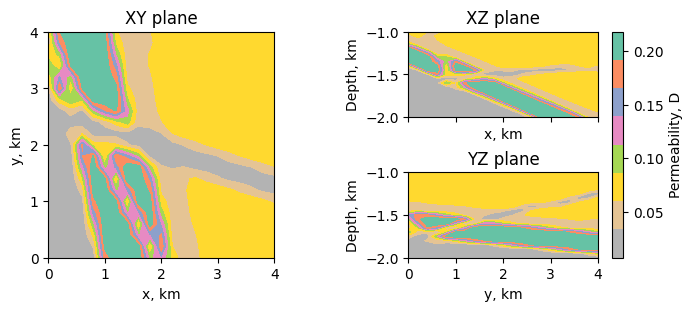

Events


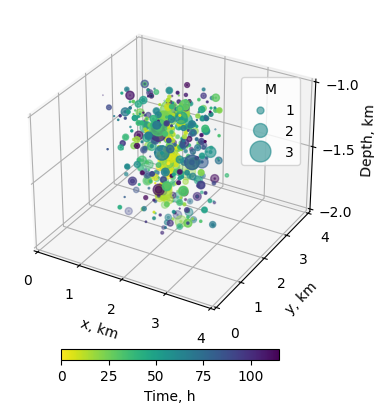

Pore pressure at the fimal step at source location slice


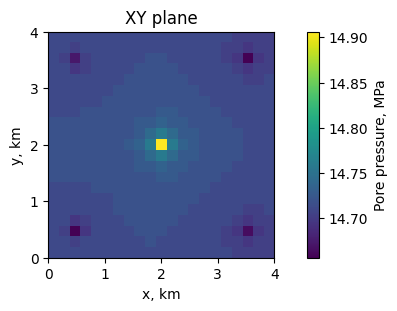

Seismic events in m3


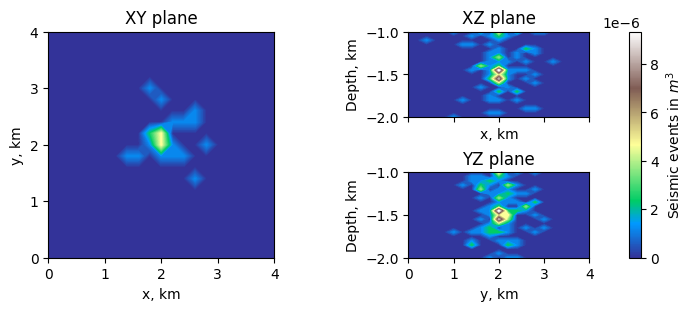

In [12]:
filename = 'permeability_models.h5'

jj = 42 # idx  for check

with h5py.File(filename, 'a') as f:
    ev = f['events'][jj]
    perm = f['perm'][jj]
    pore = f['pore'][jj]
    ev_d = f['ev_dens'][jj]

loc=(10, 10, 10)

print('Permeability map')
plot_perm(perm, loc, params)

print('Events')
plot_event_list(ev[0:980], params=params)

print('Pore pressure at the fimal step at source location slice')
plot_press_plan(pore, loc, params)

print('Seismic events in m3')
plot_ev_dens_slice(ev_d, loc, params)

### Splitting data to train and test datasets randomly

In [6]:
filename = 'permeability_models.h5'
train_name = "train.h5"
test_name = "test.h5"
split_percent = 0.8

split_hdf5_random(filename, train_name, test_name, split_percent)
print('ok')

ok
